# Create maps showing average IMD for each IVT unit catchment

Using the datafile as created from notebook 02_combine_demographic_data.ipynb, create maps of IMD for each IVT unit, showing the weighted population average.

To help with geopandas use https://github.com/MichaelAllen1966/2010_geopandas/blob/main/geopandas_1.ipynb

Two Welsh hospital catchments (CF311RQ Bridgend, CF144XW Cardiff) each contain two LSOAs that are not present in the age csv file "mid_2018_persons.csv". We use "All persons" from this datafile to calculate a weighted sum for the IVT catchment. As this value is NaN for these four LSOAs, these two related catchments do not have a value, and so are not included on the map.

Need to not include these four LSOAs (Rhondda Cynon Taf 023F, Rhondda Cynon Taf 027F, Rhondda Cynon Taf 027G, Rhondda Cynon Taf 023G) in the weighted mean.

Import libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import os
from matplotlib.transforms import Bbox
import matplotlib.colors as colors
import random
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import warnings
warnings.filterwarnings("ignore")

Load country outline

In [2]:
# Load country outline
outline = gpd.read_file('./data/Countries_(December_2022)_GB_BFC.zip')
# Drop sSotland
mask = outline['CTRY22NM'] != 'Scotland'
outline = outline[mask]
# Convert to epsg:3857
outline = outline.to_crs(epsg=3857)

Read in Index of Multiple Deprivation data (per LSOA)

In [3]:
df_lsoa = pd.read_csv(f'./data/collated_data.csv')
#df_lsoa.set_index(['LSOA'], inplace=True)

Look at first few rows

In [4]:
df_lsoa.head()

,LSOA,admissions,closest_ivt_unit,closest_ivt_unit_time,closest_mt_unit,closest_mt_unit_time,mt_transfer_time,ivt_rate,IMD2019Score,Local Authority District name (2019),...,age band males 50,age band males 55,age band males 60,age band males 65,age band males 70,age band males 75,age band males 80,age band males 85,age band males 90,age band males 95
0,Welwyn Hatfield 010F,0.666667,SG14AB,18.7,NW12BU,36.9,46.6,6.8,15.616,Welwyn Hatfield,...,66,59,28,33,28,26,14,5,3,0.0
1,Welwyn Hatfield 012A,4.000000,SG14AB,19.8,NW12BU,36.9,46.6,6.8,33.313,Welwyn Hatfield,...,60,80,53,24,18,21,12,5,4,0.0
2,Welwyn Hatfield 002F,2.000000,SG14AB,18.7,NW12BU,38.0,46.6,6.8,7.043,Welwyn Hatfield,...,54,49,41,33,28,7,5,9,2,0.0
3,Welwyn Hatfield 002E,0.666667,SG14AB,18.7,NW12BU,36.9,46.6,6.8,8.249,Welwyn Hatfield,...,60,60,41,24,17,15,16,9,1,0.0
4,Welwyn Hatfield 010A,3.333333,SG14AB,18.7,NW12BU,36.9,46.6,6.8,19.271,Welwyn Hatfield,...,62,51,39,33,28,28,13,10,3,0.0


Group data by "closest_ivt_unit" and calculate the weighted average of "Income Domain Score".

https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe

First remove the four LSOAs that do not have age data

In [5]:
mask = df_lsoa["All persons"] >= 0
df_lsoa_filtered = df_lsoa[mask]
print(f"Full dataset rows {df_lsoa.shape[0]}, filtered dataset rows {df_lsoa_filtered.shape[0]}")

Full dataset rows 34752, filtered dataset rows 34752


In [6]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=df_lsoa_filtered.loc[x.index, "All persons"])

# Groupby and aggregate with namedAgg [1]:
df_ivt_ids = df_lsoa_filtered.groupby(["closest_ivt_unit"]).agg(
            all_persons=("All persons", "sum"),  
            income_domain_score_weighted_mean=("Income Domain Score", wm))
df_ivt_ids

,all_persons,income_domain_score_weighted_mean
closest_ivt_unit,,
B152TH,963012,0.182951
B714HJ,1012389,0.202612
BA13NG,483031,0.083469
BA214AT,274432,0.095511
BB23HH,486120,0.177377
...,...,...
WD180HB,592250,0.080071
WF14DG,590899,0.148666
WR51DD,412669,0.093969


The range of people across the 113 catchments is: 87086 to 1479138
Median: 483031.0


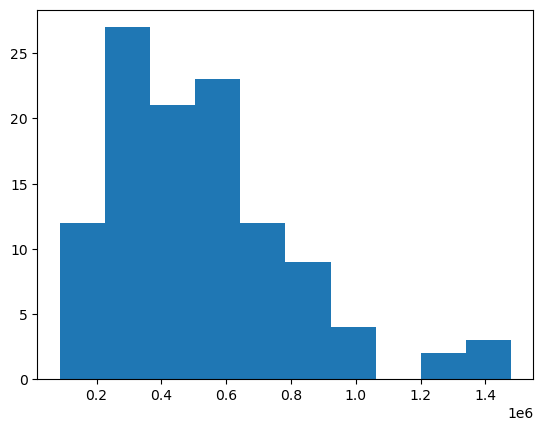

In [7]:
print(f"The range of people across the {df_ivt_ids.shape[0]} catchments is: {round(df_ivt_ids['all_persons'].min(),1)} to {round(df_ivt_ids['all_persons'].max(),1)}")
print(f"Median: {round(df_ivt_ids['all_persons'].median(),2)}")
plt.hist(df_ivt_ids['all_persons']);

Map the data.

Load IVT catchment shape file (created in notebook "03_create_ivt_catchment_shapefile_and_map.ipynb" by dissolving LSOA polygons that are in the same IVT unit catchment).

https://geopandas.org/aggregation_with_dissolve.html

The following will load the shape file of the catchments for the IVT units in England and Wales into a GeoPandas DataFrame. Note that we can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. EPSG:27700 is the crs to use when geography is in BNG (British National Grid Eastings and Northings).

EPSG:27700 OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey. Co-ordinates are in Eastings (X) and Northings (Y).
EPSG:4326 WGS 84 -- WGS84 - World Geodetic System 1984. Co-ordinates are in Longitude (X) and Latitude (Y).
EPSG:3857 - projection for displaying lat/long as a flat map

In [8]:
filename = f"data/ivt_catchment.shp"
exist = os.path.exists(filename)

if exist:
    # Read in
    gdf_ivt_catchment = gpd.read_file(filename, crs='EPSG:27700')
else:
    print('Run "03_create_ivt_catchment_shapefile_and_map.ipynb" first')
gdf_ivt_catchment.set_index(['closest_iv'], inplace=True)
gdf_ivt_catchment.head()

,LSOA11NM,LSOA11CD,LSOA11NMW,geometry
closest_iv,,,,
B152TH,Birmingham 067A,E01008881,Birmingham 067A,"MULTIPOLYGON (((403011.723 266679.152, 402597...."
B714HJ,Birmingham 037A,E01008899,Birmingham 037A,"MULTIPOLYGON (((395950.714 272162.470, 395950...."
BA13NG,Bath and North East Somerset 007A,E01014370,Bath and North East Somerset 007A,"POLYGON ((354665.594 144552.500, 354665.594 14..."
BA214AT,East Devon 005A,E01019886,East Devon 005A,"MULTIPOLYGON (((330365.588 98427.209, 330281.9..."
BB23HH,Bolton 001B,E01004803,Bolton 001B,"POLYGON ((369965.000 416593.000, 370071.000 41..."


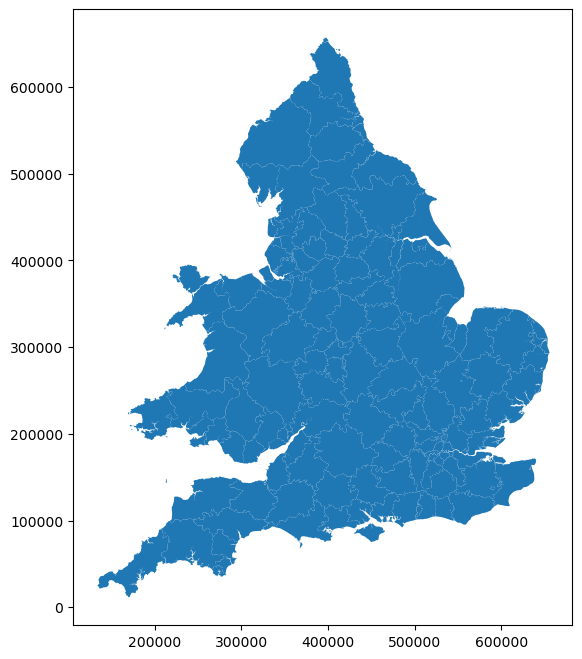

In [9]:
gdf_ivt_catchment.plot(figsize=(8,8));

IMD

In [10]:
gdf_ivt_catchment = gdf_ivt_catchment.join(df_ivt_ids['income_domain_score_weighted_mean']).reset_index()
gdf_ivt_catchment.head()

,closest_iv,LSOA11NM,LSOA11CD,LSOA11NMW,geometry,income_domain_score_weighted_mean
0,B152TH,Birmingham 067A,E01008881,Birmingham 067A,"MULTIPOLYGON (((403011.723 266679.152, 402597....",0.182951
1,B714HJ,Birmingham 037A,E01008899,Birmingham 037A,"MULTIPOLYGON (((395950.714 272162.470, 395950....",0.202612
2,BA13NG,Bath and North East Somerset 007A,E01014370,Bath and North East Somerset 007A,"POLYGON ((354665.594 144552.500, 354665.594 14...",0.083469
3,BA214AT,East Devon 005A,E01019886,East Devon 005A,"MULTIPOLYGON (((330365.588 98427.209, 330281.9...",0.095511
4,BB23HH,Bolton 001B,E01004803,Bolton 001B,"POLYGON ((369965.000 416593.000, 370071.000 41...",0.177377


Mapping data with MatPlotLib (using MatPlotLib gives us more power than the GeoPandas DataFrame plot method)

Read in hospital data
(Stroke Team, SSNAP name, Easting, Northing)

In [11]:
gdf_units = gpd.read_file('./data/stroke_hospitals_2022.csv')

gdf_units["geometry"] = gpd.points_from_xy(
        gdf_units.Easting, gdf_units.Northing)
gdf_units = gdf_units.set_crs(epsg=27700)

# Restrict to the units delivering thrombolysis
mask = gdf_units['Use_IVT']=="1"
gdf_units = gdf_units[mask]
gdf_units.head()

,Postcode,Hospital_name,Use_IVT,Use_MT,Country,Strategic Clinical Network,Health Board / Trust,Stroke Team,SSNAP name,Admissions 21/22,Thrombolysis,ivt_rate,Easting,Northing,Neuroscience,30 England Thrombectomy Example,hospital_city,Notes,geometry
0,RM70AG,RM70AG,1,1,England,London SCN,Barking; Havering and Redbridge University Hos...,"Queen's Hospital, Romford",Queens Hospital Romford HASU,981,117,11.9,551118,187780,1,0,Romford,,POINT (551118.000 187780.000)
1,E11BB,E11BB,1,1,England,London SCN,Barts Health NHS Trust,The Royal London Hospital,Royal London Hospital HASU,861,115,13.4,534829,181798,1,1,Royal London,,POINT (534829.000 181798.000)
2,SW66SX,SW66SX,1,1,England,London SCN,Imperial College Healthcare NHS Trust,"Charing Cross Hospital, London",Charing Cross Hospital HASU,1147,113,9.9,524226,176487,1,1,Charing Cross,,POINT (524226.000 176487.000)
3,SE59RW,SE59RW,1,1,England,London SCN,King's College Hospital NHS Foundation Trust,"King's College Hospital, London",King's College Hospital HASU,824,124,15,532536,176228,1,0,Kings College,,POINT (532536.000 176228.000)
4,BR68ND,BR68ND,1,0,England,London SCN,King's College Hospital NHS Foundation Trust,Princess Royal University Hospital; Orpington,Princess Royal University Hospital HASU,847,113,13.3,543443,165032,0,0,Princess Royal,,POINT (543443.000 165032.000)


In [12]:
# When using base maps convert data to epsg:3857
gdf_ivt_catchment = gdf_ivt_catchment.to_crs(epsg=3857)
gdf_units = gdf_units.to_crs(epsg=3857)

In [13]:
def add_nonoverlapping_text_labels(gdf_units, ax, col, y_step=0.05, fontsize=7):
    """
    #https://stackoverflow.com/questions/43916834/matplotlib-dynamically-change-text-position


    """

    text_rectangles = []

    # Better results if the labels are sorted descending in the y axis
    gdf_units['sort_by'] = gdf_units.geometry.y
    gdf_units.sort_values("sort_by", ascending=False, inplace=True)
    del gdf_units["sort_by"]

    # Add labels
    for x, y, label in zip(
        gdf_units.geometry.x, gdf_units.geometry.y, gdf_units[col]):
            text = ax.annotate(label, xy=(x, y), xytext=(8, 8), 
                        textcoords="offset points", fontsize=fontsize, 
                        bbox=dict(facecolor='w', alpha=0.3, edgecolor='none', boxstyle="round", pad=0.1))
            x, y = text.get_position()
            new_x = x - 2
            text.set_position((new_x, y))
                    
            rect = text.get_window_extent()

            for other_rect in text_rectangles:
                iterations = 0
                while Bbox.intersection(rect, other_rect) and iterations < 10:  # overlapping
                    x, y = text.get_position()
                    new_y = y - y_step
                    text.set_position((x, new_y))
                    rect = text.get_window_extent()
                    iterations += 1
                if iterations == 10:
                    # No improved location found; use original position
                    text.set_position((x, y))
            text_rectangles.append(rect)
    return (ax)

In [14]:
eng_wales_bounds = pd.concat([gdf_ivt_catchment['closest_iv'], gdf_ivt_catchment.bounds], axis=1)
eng_wales_bounds = eng_wales_bounds.set_index('closest_iv')
eng_wales_bounds.head()

,minx,miny,maxx,maxy
closest_iv,,,,
B152TH,-228159.802962,6.840962e+06,-186486.338536,6.891587e+06
B714HJ,-230754.673759,6.862190e+06,-174024.968174,6.926919e+06
BA13NG,-301440.775912,6.639528e+06,-220910.832420,6.742989e+06
BA214AT,-338714.448556,6.574692e+06,-241766.759874,6.661788e+06
BB23HH,-293523.883294,7.097870e+06,-227656.460963,7.179456e+06


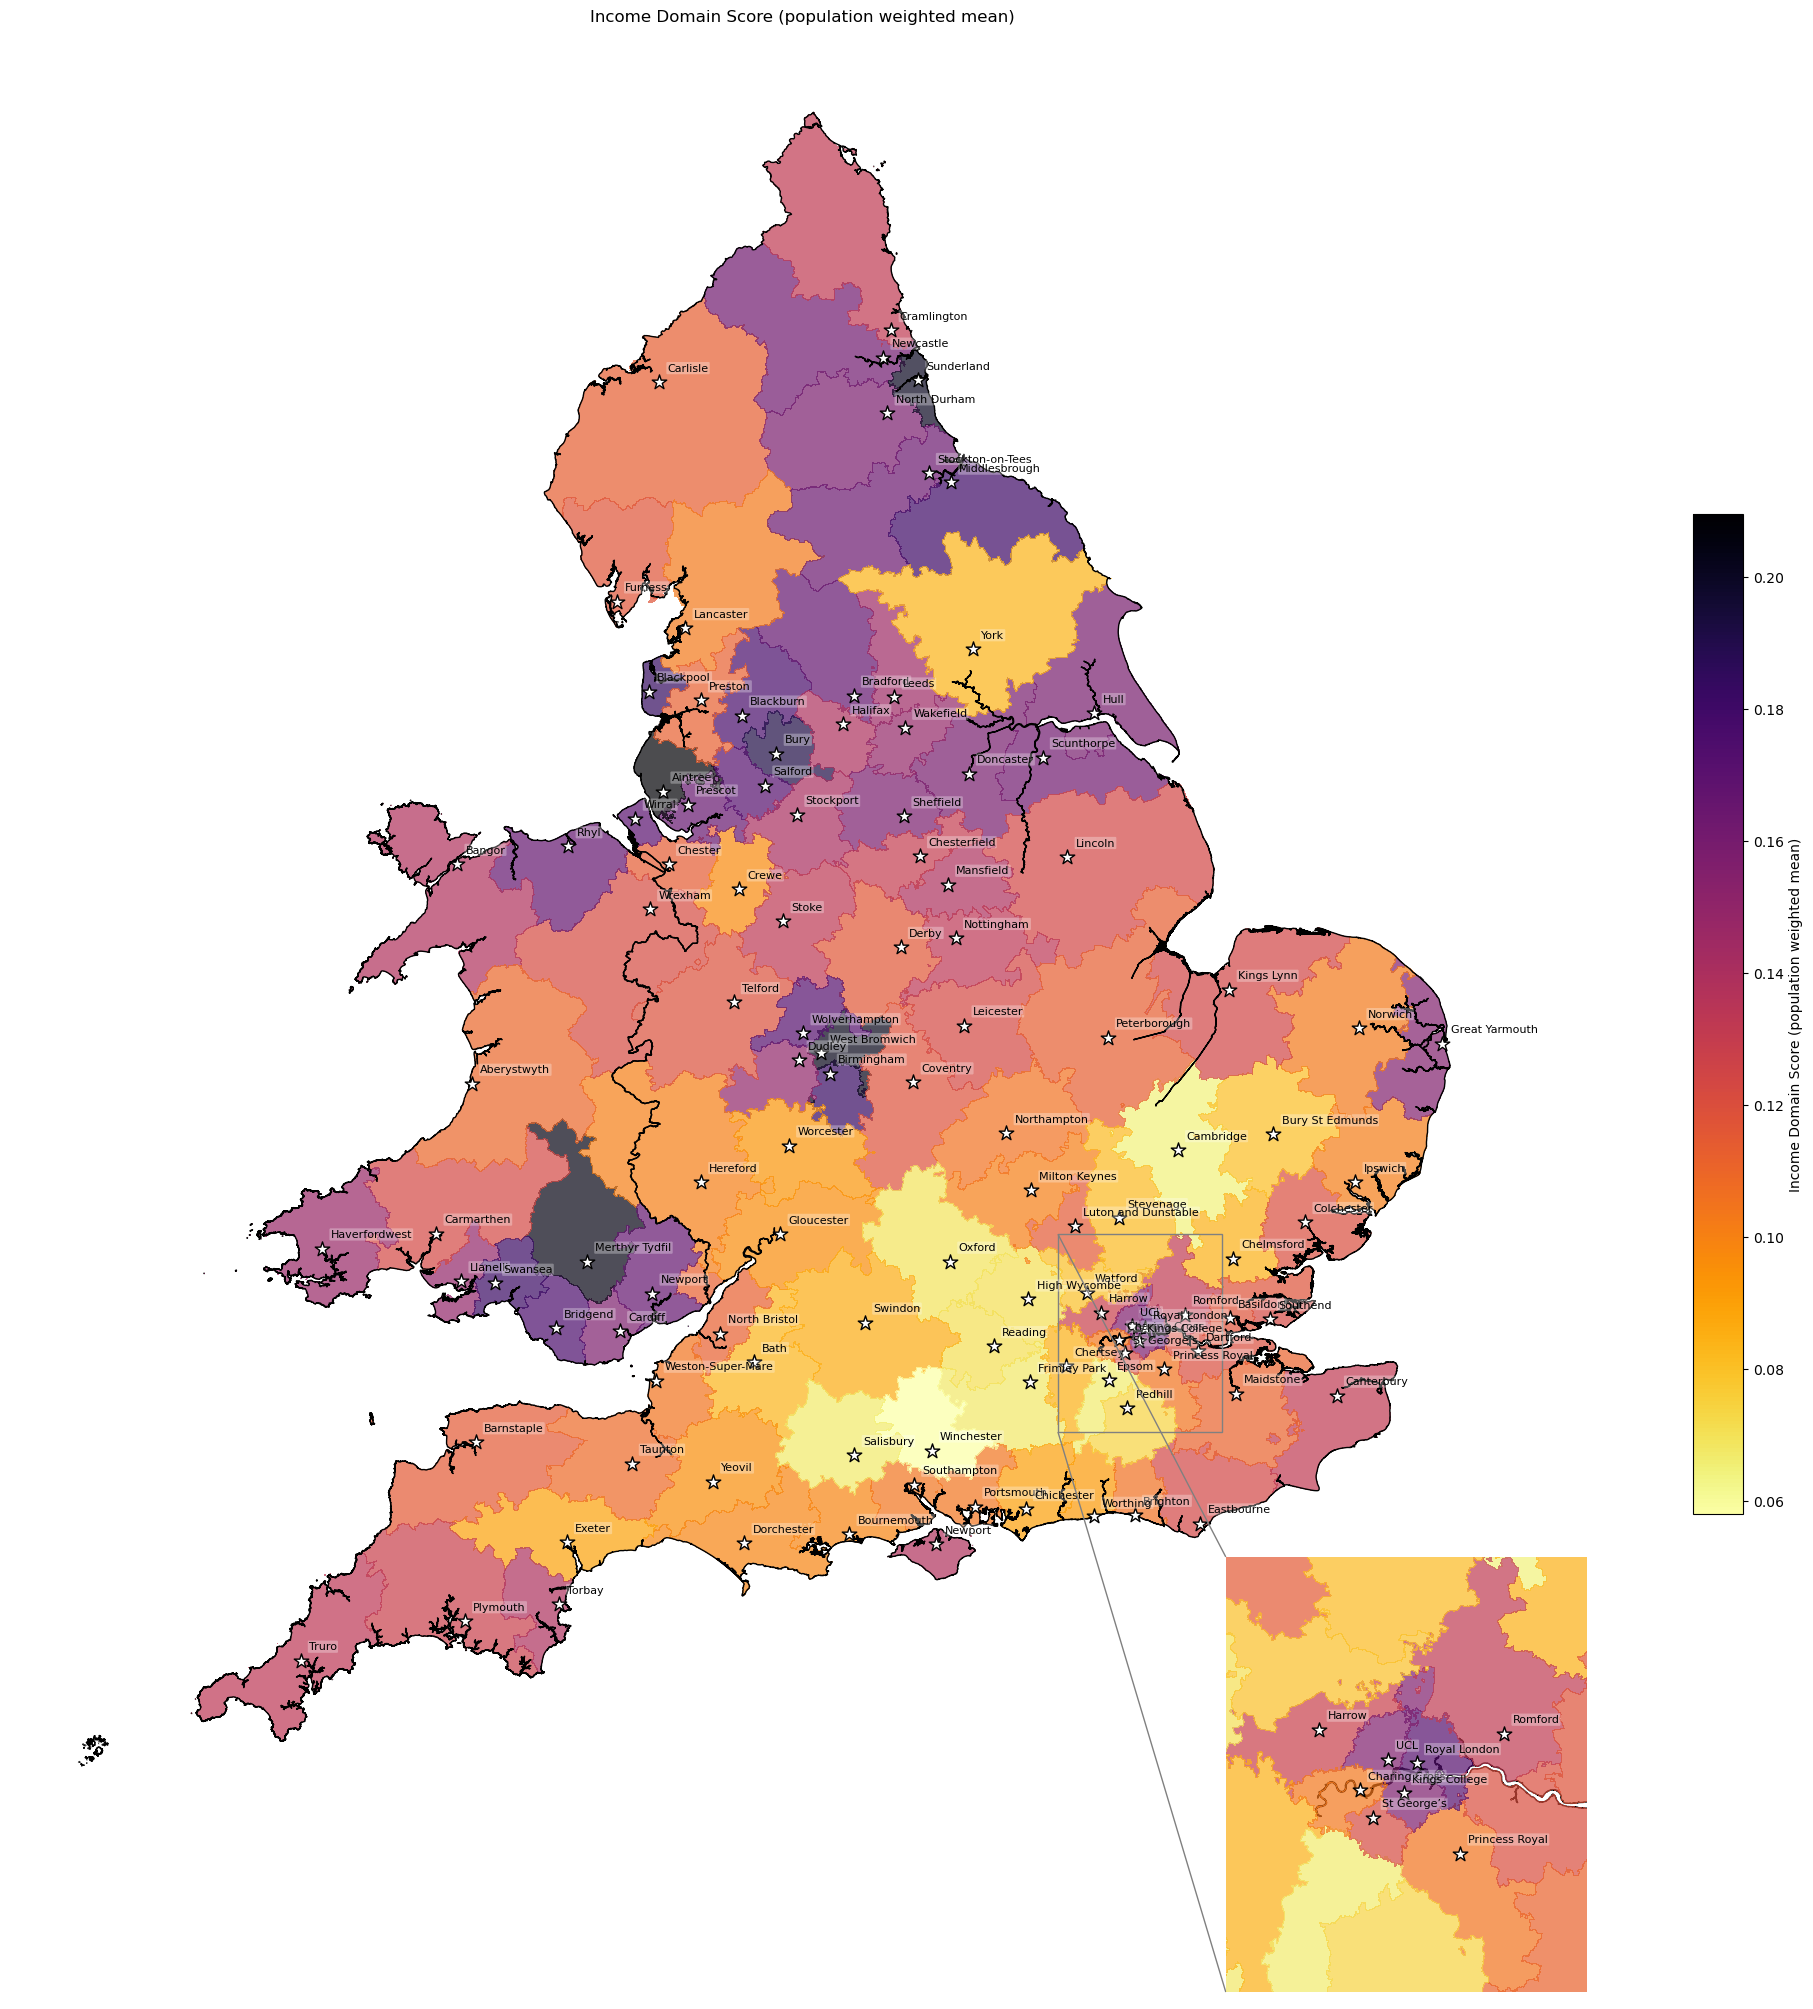

In [15]:
show_labels = True

col = 'income_domain_score_weighted_mean'
col_readable = 'Income Domain Score (population weighted mean)'

fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_ivt_catchment.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Add country boarder
outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')
if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)
        
# give some more space at bottom for london inset map
ax.set_ylim(ax.get_ylim()[0] - 100000, ax.get_ylim()[1])
# give some more space at right for hospital name label
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 50000)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
#ctx.add_basemap(ax, 
#                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Insert an inset map (loc=4 places it bottom right)
axins = zoomed_inset_axes(ax, 2.2, loc='lower right')

# Identify london hospitals to go in the inset map
london_mask = gdf_units["Strategic Clinical Network"]=="London SCN"
london_hospitals = gdf_units["Hospital_name"][london_mask].to_list()

# identify map area to plot in the inset map
# initialise exteme values
minx_ = np.inf
miny_ = np.inf
maxx_ = 0
maxy_ = 0
# Find min and max x and y for the london hospitals
for h in london_hospitals:
    minx,miny,maxx,maxy =  eng_wales_bounds.loc[h]
    minx_ = min(minx_, minx)
    miny_ = min(miny_, miny)
    maxx_ = max(maxx_, maxx)
    maxy_ = max(maxy_, maxy)

# Set extent of inset map
axins.set_xlim(minx_, maxx_)
axins.set_ylim(miny_, maxy_)

# Add country boarder
outline.plot(ax=axins, edgecolor='k', facecolor='None', linewidth=1.0)

# Define lines connecting inset map to main map
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

# Plot zoom window
gdf_ivt_catchment.plot(ax=axins, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
#                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
#                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)


# Plot location of hospitals
london_units = gdf_units[london_mask]

london_units.plot(ax=axins, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

# Label hospitals
if show_labels:
    axins = add_nonoverlapping_text_labels(london_units, axins, 'hospital_city',
                                      y_step=0.05, fontsize=8)                                     

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map

#ctx.add_basemap(ax=axins, 
#                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)
# Remove x and y ticks

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
axins.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'outputs/map_{col}.png', dpi=300)
plt.show()

In [16]:
print(f"The range of {col_readable} across the {gdf_ivt_catchment.shape[0]} catchments is: {round(gdf_ivt_catchment[col].min(),3)} to {round(gdf_ivt_catchment[col].max(),3)}")
print(f"Median: {round(gdf_ivt_catchment[col].median(),3)}")

The range of Income Domain Score (population weighted mean) across the 113 catchments is: 0.058 to 0.209
Median: 0.122


(array([ 8.,  9., 14., 20., 21.,  9., 12., 11.,  5.,  4.]),
 array([0.05801953, 0.07316567, 0.08831181, 0.10345795, 0.11860409,
        0.13375023, 0.14889637, 0.16404251, 0.17918865, 0.19433479,
        0.20948093]),
 <BarContainer object of 10 artists>)

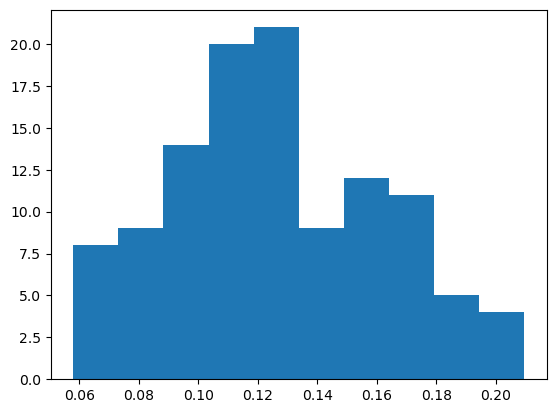

In [17]:
plt.hist(gdf_ivt_catchment[col])

Group data by "closest_ivt_unit" and calculate the weighted average of IMD (weighted by population).

https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe

In [18]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=df_lsoa.loc[x.index, "All persons"])

# Groupby and aggregate with namedAgg [1]:
df_ivt_imd = df_lsoa.groupby(["closest_ivt_unit"]).agg(
            all_persons=("All persons", "sum"),  
            imd_2019_score_weighted_mean=("IMD2019Score", wm))
df_ivt_imd

,all_persons,imd_2019_score_weighted_mean
closest_ivt_unit,,
B152TH,963012,31.488294
B714HJ,1012389,33.655519
BA13NG,483031,13.335982
BA214AT,274432,16.858199
BB23HH,486120,31.789134
...,...,...
WD180HB,592250,12.153052
WF14DG,590899,26.646876
WR51DD,412669,16.451837


Add data about IMD, joining based on 'closest_ivt_unit'

In [19]:
gdf_ivt_catchment.set_index(['closest_iv'], inplace=True)
gdf_ivt_catchment = gdf_ivt_catchment.join(df_ivt_imd['imd_2019_score_weighted_mean']).reset_index()
gdf_ivt_catchment.head()

,closest_iv,LSOA11NM,LSOA11CD,LSOA11NMW,geometry,income_domain_score_weighted_mean,imd_2019_score_weighted_mean
0,B152TH,Birmingham 067A,E01008881,Birmingham 067A,"MULTIPOLYGON (((-217881.021 6854229.965, -2185...",0.182951,31.488294
1,B714HJ,Birmingham 037A,E01008899,Birmingham 037A,"MULTIPOLYGON (((-229414.689 6863206.747, -2294...",0.202612,33.655519
2,BA13NG,Bath and North East Somerset 007A,E01014370,Bath and North East Somerset 007A,"POLYGON ((-295019.467 6656460.038, -295019.467...",0.083469,13.335982
3,BA214AT,East Devon 005A,E01019886,East Devon 005A,"MULTIPOLYGON (((-332743.148 6582685.222, -3328...",0.095511,16.858199
4,BB23HH,Bolton 001B,E01004803,Bolton 001B,"POLYGON ((-273379.385 7103203.659, -273199.724...",0.177377,31.789134


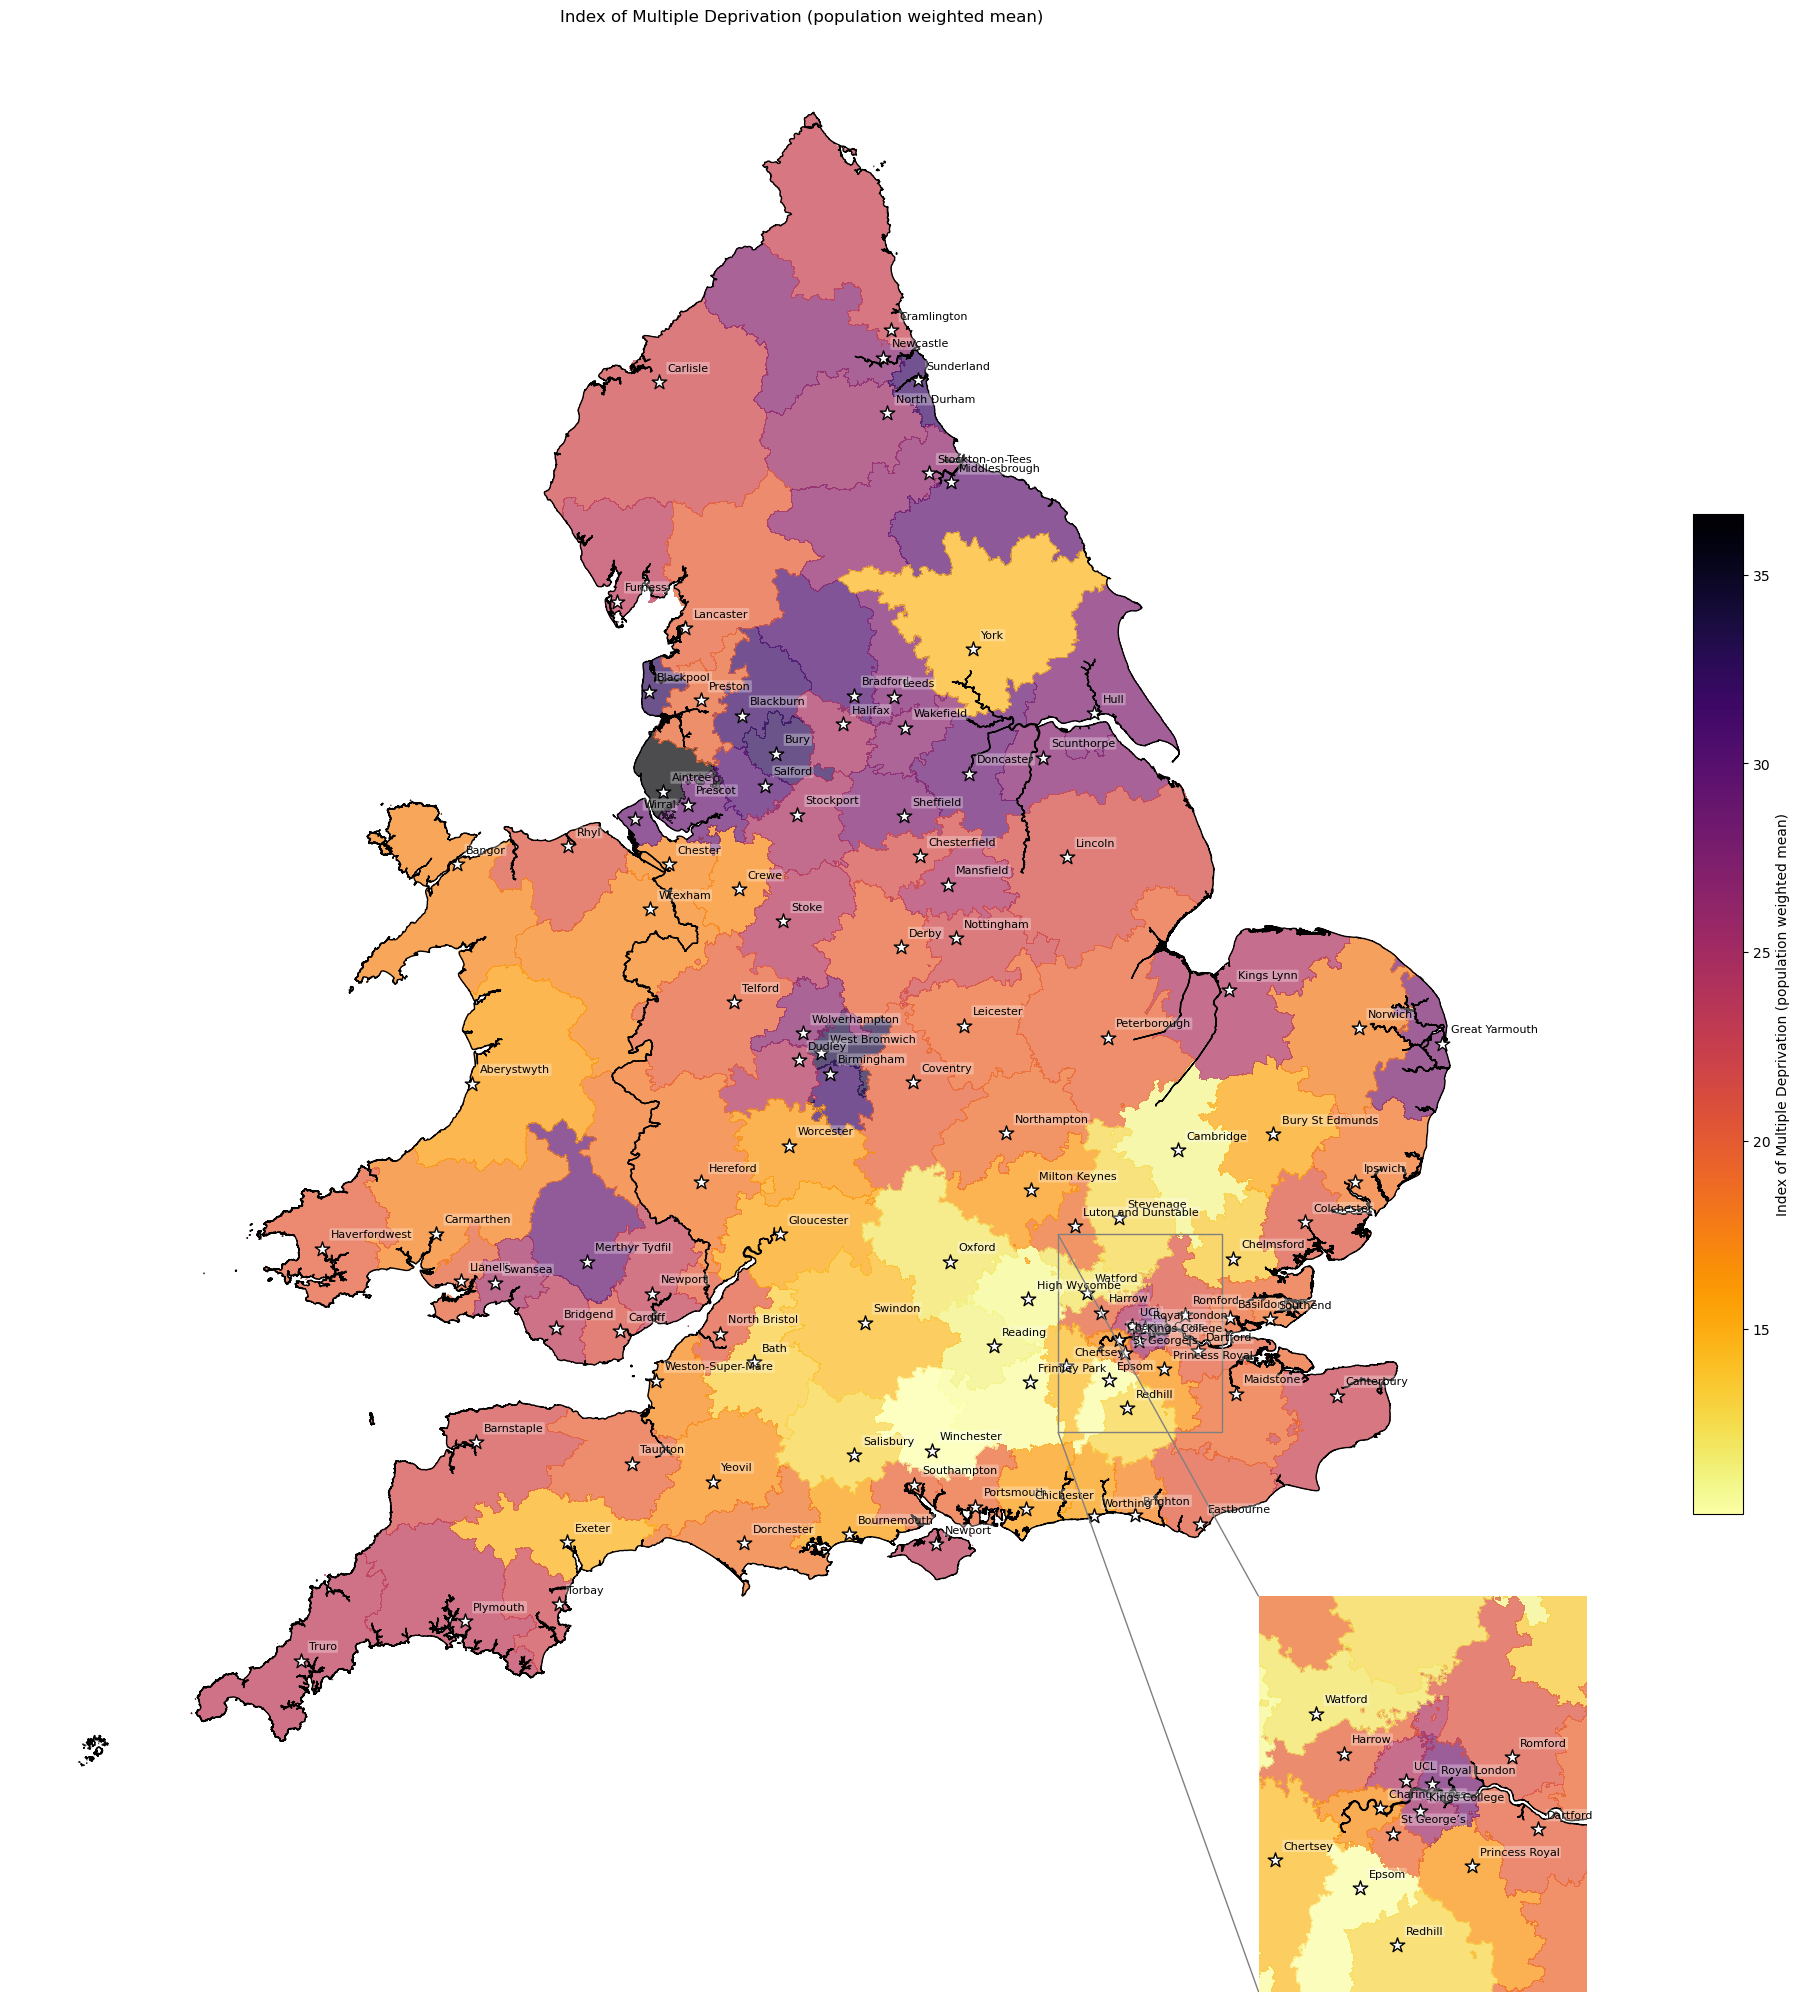

In [21]:
show_labels = True

col = 'imd_2019_score_weighted_mean'
col_readable = 'Index of Multiple Deprivation (population weighted mean)'

fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_ivt_catchment.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Add country boarder
outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')


if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)
        
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
#ctx.add_basemap(ax, 
#                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# give some more space at bottom for london inset map
ax.set_ylim(ax.get_ylim()[0] - 100000, ax.get_ylim()[1])
# give some more space at right for hospital name label
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 50000)


# Insert an inset map (loc=4 places it bottom right)
axins = zoomed_inset_axes(ax, 2, loc=4)

# Identify london hospitals to go in the inset map
mask = gdf_units["Strategic Clinical Network"]=="London SCN"
london_hospitals = gdf_units["Hospital_name"][mask].to_list()

# identify map area to plot in the inset map
# initialise exteme values
minx_ = np.inf
miny_ = np.inf
maxx_ = 0
maxy_ = 0
# Find min and max x and y for the london hospitals
for h in london_hospitals:
    minx,miny,maxx,maxy =  eng_wales_bounds.loc[h]
    minx_ = min(minx_, minx)
    miny_ = min(miny_, miny)
    maxx_ = max(maxx_, maxx)
    maxy_ = max(maxy_, maxy)

# Set extent of inset map
axins.set_xlim(minx_, maxx_)
axins.set_ylim(miny_, maxy_)

# Define lines connecting inset map to main map
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

# Plot zoom window
gdf_ivt_catchment.plot(ax=axins, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
#                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
#                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Add country boarder
outline.plot(ax=axins, edgecolor='k', facecolor='None', linewidth=1.0)

# Plot location of hospitals
gdf_units.plot(ax=axins, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

# Label hospitals
if show_labels:
    axins = add_nonoverlapping_text_labels(gdf_units, axins, 'hospital_city',
                                        y_step=0.05, fontsize=8)
    
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
#ctx.add_basemap(ax=axins, 
#                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Remove x and y ticks
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
axins.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'outputs/map_{col}.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2) # Save figure
plt.show()

In [ ]:
print(f"The range of {col_readable} across the {gdf_ivt_catchment.shape[0]} catchments is: {round(gdf_ivt_catchment[col].min(),2)} to {round(gdf_ivt_catchment[col].max(),2)}")
print(f"Median: {round(gdf_ivt_catchment[col].median(),2)}")

In [ ]:
plt.hist(gdf_ivt_catchment[col]);